# Install Necessary Packages

In [1]:
# Install necessary packages
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install gcsfs
!pip install scikit-learn numpy pandas Pillow opencv-python matplotlib albumentations tqdm torch-optimizer google-cloud-storage
!pip install torch==2.3.1+cu121 torchvision==0.18.1+cu121 -f https://download.pytorch.org/whl/torch_stable.html
!pip install nvidia-pyindex

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-gz09d3pc
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-gz09d3pc
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp310-cp310-linux_x86_64.whl size=3405186 sha256=173d328f2b109881852c792206c4d0d76f4d7d0a491b39b63ac8aed903744546
  Stored in directory: /tmp/pip-ephem-wheel-cache-89t3awdc/wheels/01/5b/61/87443ed3bf03dd2940375cf2f8b6fba88efece935465e490b0
Successfully built pydensecrf
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 991.0 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu

# Import Libraries

In [2]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from PIL import Image
import copy
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
import shutil
import time
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch_optimizer as optim_lookahead
import gcsfs
from torch.cuda.amp import GradScaler, autocast

# Authenticate Google Cloud Account

In [3]:
# Upload the JSON key file to Colab
from google.colab import files
uploaded = files.upload()

Saving service_account_key.json to service_account_key.json


In [4]:
# Assuming the JSON key file is named 'service_account_key.json'
key_file = 'service_account_key.json'

In [5]:
# Set the environment variable for authentication
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_file

In [6]:
# Authenticate with Google Cloud
!gcloud auth activate-service-account --key-file $key_file

# Set your Google Cloud project
project_id = 'medicalsegmentationunet'
!gcloud config set project {project_id}

Activated service account credentials for: [jervissaldanha@medicalsegmentationunet.iam.gserviceaccount.com]
- '@type': type.googleapis.com/google.rpc.Help
  links:
  - description: Google developers console API activation
    url: https://console.developers.google.com/apis/api/cloudresourcemanager.googleapis.com/overview?project=529856239230
- '@type': type.googleapis.com/google.rpc.ErrorInfo
  domain: googleapis.com
  metadata:
    consumer: projects/529856239230
    service: cloudresourcemanager.googleapis.com
  reason: SERVICE_DISABLED
Are you sure you wish to set property [core/project] to medicalsegmentationunet?

Do you want to continue (Y/n)?  Y

Updated property [core/project].


# Define Network Components

In [7]:
# Combined Loss Functions with Lambda = 3.5

In [8]:
# Define SwitchNorm2d
class SwitchNorm2d(nn.Module):
    def __init__(self, num_features):
        super(SwitchNorm2d, self).__init__()
        self.weight = nn.Parameter(torch.ones(num_features))
        self.bias = nn.Parameter(torch.zeros(num_features))
        self.mean_weight = nn.Parameter(torch.ones(3) / 3)
        self.var_weight = nn.Parameter(torch.ones(3) / 3)
        self.eps = 1e-5

    def forward(self, x):
        mean_in = x.mean(1, keepdim=True)
        var_in = x.var(1, keepdim=True)
        mean_ln = x.mean([1, 2, 3], keepdim=True)
        var_ln = x.var([1, 2, 3], keepdim=True)
        mean_bn = x.mean([0, 2, 3], keepdim=True)
        var_bn = x.var([0, 2, 3], keepdim=True)

        mean = self.mean_weight[0] * mean_in + self.mean_weight[1] * mean_ln + self.mean_weight[2] * mean_bn
        var = self.var_weight[0] * var_in + self.var_weight[1] * var_ln + self.var_weight[2] * var_bn

        x = (x - mean) / (torch.sqrt(var + self.eps))
        return x * self.weight.view(1, -1, 1, 1) + self.bias.view(1, -1, 1, 1)


In [9]:
# Define AttentionBlock
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


In [10]:
# Define ResidualBlock with Dropout
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.sn1 = SwitchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout_prob)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.sn2 = SwitchNorm2d(out_channels)

        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.residual_conv = None

    def forward(self, x):
        residual = x
        if self.residual_conv:
            residual = self.residual_conv(x)

        out = self.conv1(x)
        out = self.sn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.sn2(out)
        out += residual
        out = self.relu(out)
        return out


In [11]:
# Define ASPP (Atrous Spatial Pyramid Pooling)
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=6, dilation=6)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=12, dilation=12)
        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=18, dilation=18)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.conv5 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.conv6 = nn.Conv2d(out_channels * 5, out_channels, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        x5 = self.pool(x)
        x5 = self.conv5(x5)
        x5 = nn.functional.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)

        x = torch.cat([x1, x2, x3, x4, x5], dim=1)
        x = self.conv6(x)
        return self.relu(x)


# Define UNet3Plus with ASPP and Residual Attention Blocks

In [12]:
# Define UNet3Plus with ASPP and residual attention blocks
class UNet3Plus(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet3Plus, self).__init__()
        filters = [64, 128, 256, 512, 1024]

        self.conv1 = ResidualBlock(in_channels, filters[0])
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = ResidualBlock(filters[0], filters[1])
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = ResidualBlock(filters[1], filters[2])
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = ResidualBlock(filters[2], filters[3])
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = ResidualBlock(filters[3], filters[4])

        self.aspp = ASPP(filters[4], filters[4])

        self.up5 = nn.ConvTranspose2d(filters[4], filters[3], kernel_size=2, stride=2)
        self.att5 = AttentionBlock(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.up_conv5 = ResidualBlock(filters[4], filters[3])

        self.up4 = nn.ConvTranspose2d(filters[3], filters[2], kernel_size=2, stride=2)
        self.att4 = AttentionBlock(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.up_conv4 = ResidualBlock(filters[3], filters[2])

        self.up3 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=2, stride=2)
        self.att3 = AttentionBlock(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.up_conv3 = ResidualBlock(filters[2], filters[1])

        self.up2 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=filters[0], F_l=filters[0], F_int=32)
        self.up_conv2 = ResidualBlock(filters[1], filters[0])

        self.final_conv = nn.Conv2d(filters[0], out_channels, kernel_size=1)

        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        c1 = self.conv1(x)
        p1 = self.maxpool1(c1)

        c2 = self.conv2(p1)
        p2 = self.maxpool2(c2)

        c3 = self.conv3(p2)
        p3 = self.maxpool3(c3)

        c4 = self.conv4(p3)
        p4 = self.maxpool4(c4)

        c5 = self.conv5(p4)
        c5 = self.aspp(c5)

        # Decoder
        u5 = self.up5(c5)
        a5 = self.att5(g=u5, x=c4)
        u5 = torch.cat((a5, u5), dim=1)
        u5 = self.up_conv5(u5)

        u4 = self.up4(u5)
        a4 = self.att4(g=u4, x=c3)
        u4 = torch.cat((a4, u4), dim=1)
        u4 = self.up_conv4(u4)

        u3 = self.up3(u4)
        a3 = self.att3(g=u3, x=c2)
        u3 = torch.cat((a3, u3), dim=1)
        u3 = self.up_conv3(u3)

        u2 = self.up2(u3)
        a2 = self.att2(g=u2, x=c1)
        u2 = torch.cat((a2, u2), dim=1)
        u2 = self.up_conv2(u2)

        outputs = self.final_conv(u2)
        return outputs


# Custom Loss Functions

In [13]:
# Custom Combined Loss Function
class CombinedLoss(nn.Module):
    def __init__(self, lambda_dice=3.5):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.lambda_dice = lambda_dice

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        return bce_loss + self.lambda_dice * dice_loss

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1).float()  # Ensure targets are float
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice


# Dataset Preparation

In [14]:
# Dataset Preparation
class BrainMRIDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.fs = gcsfs.GCSFileSystem()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        mask_path = self.dataframe.iloc[idx, 1]

        with self.fs.open(img_path, 'rb') as f:
            image = Image.open(f).convert("RGB")
        with self.fs.open(mask_path, 'rb') as f:
            mask = Image.open(f).convert("L")

        if self.transform:
            augmented = self.transform(image=np.array(image), mask=np.array(mask))
            image = augmented['image']
            mask = augmented['mask']

        # Ensure the mask has a channel dimension and is of float type
        mask = np.expand_dims(mask, axis=0).astype(np.float32)

        return image, mask

def get_dataset_dataframe(bucket_name, data_path):
    fs = gcsfs.GCSFileSystem()
    image_files = fs.glob(f"{bucket_name}/{data_path}/**/*.tif")
    images = []
    masks = []
    for file in image_files:
        if "mask" not in file:
            image_path = f"gs://{file}"
            mask_path = file.replace(".tif", "_mask.tif")
            if fs.exists(mask_path):  # Ensure the corresponding mask exists
                images.append(image_path)
                masks.append(f"gs://{mask_path}")
    images.sort()
    masks.sort()
    dataframe = pd.DataFrame({"image_path": images, "mask_path": masks})
    return dataframe


# CRF Post-Processing and Morphological Operations

In [15]:
# CRF Post-processing and Morphological Operations
def apply_crf(image, mask):
    image = np.ascontiguousarray(image)
    mask = np.ascontiguousarray(mask)
    d = dcrf.DenseCRF2D(image.shape[1], image.shape[0], 2)
    unary = unary_from_softmax(mask)
    d.setUnaryEnergy(unary)
    d.addPairwiseGaussian(sxy=3, compat=3)
    d.addPairwiseBilateral(sxy=80, srgb=13, rgbim=image, compat=10)
    Q = d.inference(5)
    res = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))
    return res

def apply_morphological_operations(mask):
    kernel = np.ones((5,5),np.uint8)
    mask = cv2.dilate(mask, kernel, iterations = 1)
    mask = cv2.erode(mask, kernel, iterations = 1)
    return mask


# Custom Optimizer with Warm Restarts

In [16]:
# # Custom Optimizer with Warm Restarts
# class CustomRangerSGD:
#     def __init__(self, model_parameters, lr=1e-6, weight_decay=1e-4, t0=10, t_mult=1):
#         self.ranger = optim_lookahead.Ranger(model_parameters, lr=lr, weight_decay=weight_decay)
#         self.scheduler = CosineAnnealingWarmRestarts(self.ranger, T_0=t0, T_mult=t_mult)

#     def step(self):
#         self.ranger.step()

#     def zero_grad(self):
#         self.ranger.zero_grad()

#     def scheduler_step(self):
#         self.scheduler.step()


In [17]:
# Custom Optimizer with Warm Restarts
class CustomRangerSGD(optim_lookahead.Ranger):
    def __init__(self, model_parameters, lr=1e-6, weight_decay=1e-4, t0=10, t_mult=1):
        super(CustomRangerSGD, self).__init__(model_parameters, lr=lr, weight_decay=weight_decay)
        self.scheduler = CosineAnnealingWarmRestarts(self, T_0=t0, T_mult=t_mult)

    def scheduler_step(self):
        self.scheduler.step()


# Training Function

In [18]:
# Training Function
def train_model_with_custom_optimizer(model, train_loader, val_loader, criterion, custom_optimizer, num_epochs, device, ckp_path):
    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    loss_history = []
    train_history = []
    val_history = []

    train_loss_history = []  # Store training loss
    val_loss_history = []    # Store validation loss
    train_accuracy_history = []  # Store training accuracy

    scaler = GradScaler()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        dice_score = 0.0
        correct_predictions = 0
        total_predictions = 0

        for inputs, targets in tqdm(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device).float()  # Ensure targets are float
            custom_optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Apply gradient clipping
            scaler.step(custom_optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            dice_score += 1 - loss.item()

            # Calculate accuracy
            predicted = torch.sigmoid(outputs) > 0.5
            correct_predictions += (predicted == targets).sum().item()
            total_predictions += targets.numel()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_dice = dice_score / len(train_loader.dataset)
        epoch_accuracy = correct_predictions / total_predictions

        loss_history.append(epoch_loss)
        train_history.append(epoch_dice)
        train_accuracy_history.append(epoch_accuracy)

        print(f'Mean Combined Loss on train: {epoch_loss:.4f}, Mean Combined Loss Score on train: {epoch_dice:.4f}, Training Accuracy: {epoch_accuracy:.4f}')

        model.eval()
        val_loss = 0.0
        val_dice = 0.0

        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).float()  # Ensure targets are float
            with torch.no_grad():
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                val_dice += 1 - loss.item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_dice = val_dice / len(val_loader.dataset)
        val_history.append(val_epoch_dice)
        val_loss_history.append(val_epoch_loss)  # Store validation loss

        print(f'Mean Combined Loss on validation: {val_epoch_loss:.4f}, Mean Combined Loss Score on validation: {val_epoch_dice:.4f}')

        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        custom_optimizer.scheduler_step()

    print(f'Best val Loss: {best_loss:4f}')
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), ckp_path)
    return loss_history, train_history, val_history, train_loss_history, val_loss_history, train_accuracy_history



# Plotting Functions

In [19]:
# Plotting Functions
def plot_model_history(model_name, train_history, val_history, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), train_history, 'b', label='Training Combined Loss Score')
    plt.plot(range(num_epochs), val_history, 'r', label='Validation Combined Loss Score')
    plt.title(f'Training and Validation Combined Loss for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Combined Loss Score')
    plt.legend()
    plt.show()

def plot_loss_history(train_loss_history, val_loss_history, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), train_loss_history, 'b', label='Training Loss')
    plt.plot(range(num_epochs), val_loss_history, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy_history(train_accuracy_history, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), train_accuracy_history, 'g', label='Training Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


# Main Execution

In [20]:
# Main Execution
bucket_name = 'medicalsegmentation_test'
data_path = 'Kaggle_3m'
dataframe = get_dataset_dataframe(bucket_name, data_path)
print(f"Total samples: {len(dataframe)}")

if len(dataframe) == 0:
    raise ValueError("No data found. Please check the dataset path and structure.")

train_df, val_df = train_test_split(dataframe, test_size=0.2, random_state=42)

transform = A.Compose([
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

train_dataset = BrainMRIDataset(train_df, transform=transform)
val_dataset = BrainMRIDataset(val_df, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3Plus(in_channels=3, out_channels=1)

# Initialize the combined loss function with lambda = 3.5
lambda_dice = 3.5
criterion = CombinedLoss(lambda_dice=lambda_dice)

# Initialize the custom optimizer
custom_optimizer = CustomRangerSGD(model.parameters(), lr=1e-6, weight_decay=1e-4, t0=10, t_mult=1)

# Train the model with the custom optimizer and scheduler
loss_history, train_history, val_history, train_loss_history, val_loss_history, train_accuracy_history = train_model_with_custom_optimizer(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    criterion=criterion,
    custom_optimizer=custom_optimizer,
    num_epochs=250,  # Increase the number of epochs for a full training cycle
    device=device,
    ckp_path="unet3plus_resattn.pth"
)


Total samples: 3929
Epoch 0/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_ranger/ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1578.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


Mean Combined Loss on train: 0.3628, Mean Combined Loss Score on train: 0.0797, Training Accuracy: 0.2347
Mean Combined Loss on validation: -0.1622, Mean Combined Loss Score on validation: 0.1492
Epoch 1/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: 0.2148, Mean Combined Loss Score on train: 0.0981, Training Accuracy: 0.2336
Mean Combined Loss on validation: -0.2191, Mean Combined Loss Score on validation: 0.1565
Epoch 2/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: 0.1690, Mean Combined Loss Score on train: 0.1038, Training Accuracy: 0.2331
Mean Combined Loss on validation: -0.2794, Mean Combined Loss Score on validation: 0.1641
Epoch 3/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: 0.1057, Mean Combined Loss Score on train: 0.1118, Training Accuracy: 0.2258
Mean Combined Loss on validation: -0.3430, Mean Combined Loss Score on validation: 0.1722
Epoch 4/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: 0.2116, Mean Combined Loss Score on train: 0.0987, Training Accuracy: 0.2233
Mean Combined Loss on validation: -0.3844, Mean Combined Loss Score on validation: 0.1774
Epoch 5/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: 0.1518, Mean Combined Loss Score on train: 0.1060, Training Accuracy: 0.2214
Mean Combined Loss on validation: -0.4454, Mean Combined Loss Score on validation: 0.1852
Epoch 6/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: 0.0884, Mean Combined Loss Score on train: 0.1140, Training Accuracy: 0.2150
Mean Combined Loss on validation: -0.4827, Mean Combined Loss Score on validation: 0.1898
Epoch 7/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: 0.1094, Mean Combined Loss Score on train: 0.1113, Training Accuracy: 0.2139
Mean Combined Loss on validation: -0.5284, Mean Combined Loss Score on validation: 0.1957
Epoch 8/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: 0.0770, Mean Combined Loss Score on train: 0.1155, Training Accuracy: 0.2131
Mean Combined Loss on validation: -0.5431, Mean Combined Loss Score on validation: 0.1975
Epoch 9/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: 0.0875, Mean Combined Loss Score on train: 0.1141, Training Accuracy: 0.2131
Mean Combined Loss on validation: -0.5550, Mean Combined Loss Score on validation: 0.1991
Epoch 10/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: 0.0167, Mean Combined Loss Score on train: 0.1229, Training Accuracy: 0.2073
Mean Combined Loss on validation: -0.7304, Mean Combined Loss Score on validation: 0.2213
Epoch 11/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.1654, Mean Combined Loss Score on train: 0.1457, Training Accuracy: 0.2011
Mean Combined Loss on validation: -0.9106, Mean Combined Loss Score on validation: 0.2441
Epoch 12/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.2775, Mean Combined Loss Score on train: 0.1598, Training Accuracy: 0.1899
Mean Combined Loss on validation: -0.9970, Mean Combined Loss Score on validation: 0.2551
Epoch 13/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.1535, Mean Combined Loss Score on train: 0.1442, Training Accuracy: 0.1883
Mean Combined Loss on validation: -1.0667, Mean Combined Loss Score on validation: 0.2640
Epoch 14/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.3167, Mean Combined Loss Score on train: 0.1648, Training Accuracy: 0.1844
Mean Combined Loss on validation: -1.1361, Mean Combined Loss Score on validation: 0.2728
Epoch 15/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.3271, Mean Combined Loss Score on train: 0.1661, Training Accuracy: 0.1776
Mean Combined Loss on validation: -1.1996, Mean Combined Loss Score on validation: 0.2808
Epoch 16/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.2950, Mean Combined Loss Score on train: 0.1620, Training Accuracy: 0.1775
Mean Combined Loss on validation: -1.2395, Mean Combined Loss Score on validation: 0.2859
Epoch 17/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.3273, Mean Combined Loss Score on train: 0.1658, Training Accuracy: 0.1777
Mean Combined Loss on validation: -1.2377, Mean Combined Loss Score on validation: 0.2857
Epoch 18/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.4386, Mean Combined Loss Score on train: 0.1799, Training Accuracy: 0.1716
Mean Combined Loss on validation: -1.2519, Mean Combined Loss Score on validation: 0.2875
Epoch 19/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.3150, Mean Combined Loss Score on train: 0.1646, Training Accuracy: 0.1774
Mean Combined Loss on validation: -1.2555, Mean Combined Loss Score on validation: 0.2879
Epoch 20/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.3934, Mean Combined Loss Score on train: 0.1742, Training Accuracy: 0.1726
Mean Combined Loss on validation: -1.3546, Mean Combined Loss Score on validation: 0.3005
Epoch 21/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.4034, Mean Combined Loss Score on train: 0.1754, Training Accuracy: 0.1672
Mean Combined Loss on validation: -1.4809, Mean Combined Loss Score on validation: 0.3165
Epoch 22/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.4211, Mean Combined Loss Score on train: 0.1777, Training Accuracy: 0.1597
Mean Combined Loss on validation: -1.5453, Mean Combined Loss Score on validation: 0.3247
Epoch 23/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.5103, Mean Combined Loss Score on train: 0.1887, Training Accuracy: 0.1601
Mean Combined Loss on validation: -1.6059, Mean Combined Loss Score on validation: 0.3324
Epoch 24/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.6963, Mean Combined Loss Score on train: 0.2121, Training Accuracy: 0.1543
Mean Combined Loss on validation: -1.6868, Mean Combined Loss Score on validation: 0.3426
Epoch 25/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.5569, Mean Combined Loss Score on train: 0.1948, Training Accuracy: 0.1510
Mean Combined Loss on validation: -1.7569, Mean Combined Loss Score on validation: 0.3515
Epoch 26/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.6336, Mean Combined Loss Score on train: 0.2042, Training Accuracy: 0.1504
Mean Combined Loss on validation: -1.7781, Mean Combined Loss Score on validation: 0.3542
Epoch 27/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.7127, Mean Combined Loss Score on train: 0.2144, Training Accuracy: 0.1490
Mean Combined Loss on validation: -1.7945, Mean Combined Loss Score on validation: 0.3563
Epoch 28/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.7170, Mean Combined Loss Score on train: 0.2147, Training Accuracy: 0.1481
Mean Combined Loss on validation: -1.8056, Mean Combined Loss Score on validation: 0.3577
Epoch 29/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.6612, Mean Combined Loss Score on train: 0.2076, Training Accuracy: 0.1492
Mean Combined Loss on validation: -1.8136, Mean Combined Loss Score on validation: 0.3587
Epoch 30/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.6586, Mean Combined Loss Score on train: 0.2072, Training Accuracy: 0.1441
Mean Combined Loss on validation: -1.9321, Mean Combined Loss Score on validation: 0.3737
Epoch 31/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.7457, Mean Combined Loss Score on train: 0.2182, Training Accuracy: 0.1406
Mean Combined Loss on validation: -2.0297, Mean Combined Loss Score on validation: 0.3861
Epoch 32/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.8996, Mean Combined Loss Score on train: 0.2375, Training Accuracy: 0.1353
Mean Combined Loss on validation: -2.1205, Mean Combined Loss Score on validation: 0.3976
Epoch 33/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.9674, Mean Combined Loss Score on train: 0.2461, Training Accuracy: 0.1309
Mean Combined Loss on validation: -2.2104, Mean Combined Loss Score on validation: 0.4090
Epoch 34/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.8572, Mean Combined Loss Score on train: 0.2322, Training Accuracy: 0.1297
Mean Combined Loss on validation: -2.2678, Mean Combined Loss Score on validation: 0.4163
Epoch 35/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.9611, Mean Combined Loss Score on train: 0.2454, Training Accuracy: 0.1266
Mean Combined Loss on validation: -2.3224, Mean Combined Loss Score on validation: 0.4233
Epoch 36/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.0239, Mean Combined Loss Score on train: 0.2531, Training Accuracy: 0.1252
Mean Combined Loss on validation: -2.3441, Mean Combined Loss Score on validation: 0.4260
Epoch 37/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -0.9728, Mean Combined Loss Score on train: 0.2467, Training Accuracy: 0.1276
Mean Combined Loss on validation: -2.3855, Mean Combined Loss Score on validation: 0.4313
Epoch 38/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.0984, Mean Combined Loss Score on train: 0.2628, Training Accuracy: 0.1224
Mean Combined Loss on validation: -2.3852, Mean Combined Loss Score on validation: 0.4312
Epoch 39/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.1284, Mean Combined Loss Score on train: 0.2659, Training Accuracy: 0.1208
Mean Combined Loss on validation: -2.3824, Mean Combined Loss Score on validation: 0.4309
Epoch 40/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.0597, Mean Combined Loss Score on train: 0.2575, Training Accuracy: 0.1212
Mean Combined Loss on validation: -2.4698, Mean Combined Loss Score on validation: 0.4419
Epoch 41/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.0931, Mean Combined Loss Score on train: 0.2619, Training Accuracy: 0.1172
Mean Combined Loss on validation: -2.5717, Mean Combined Loss Score on validation: 0.4549
Epoch 42/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.1426, Mean Combined Loss Score on train: 0.2678, Training Accuracy: 0.1145
Mean Combined Loss on validation: -2.6529, Mean Combined Loss Score on validation: 0.4652
Epoch 43/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.3132, Mean Combined Loss Score on train: 0.2892, Training Accuracy: 0.1086
Mean Combined Loss on validation: -2.7598, Mean Combined Loss Score on validation: 0.4788
Epoch 44/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.3064, Mean Combined Loss Score on train: 0.2882, Training Accuracy: 0.1078
Mean Combined Loss on validation: -2.8125, Mean Combined Loss Score on validation: 0.4854
Epoch 45/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.2729, Mean Combined Loss Score on train: 0.2840, Training Accuracy: 0.1055
Mean Combined Loss on validation: -2.8781, Mean Combined Loss Score on validation: 0.4938
Epoch 46/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.3566, Mean Combined Loss Score on train: 0.2947, Training Accuracy: 0.1051
Mean Combined Loss on validation: -2.8997, Mean Combined Loss Score on validation: 0.4965
Epoch 47/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.4183, Mean Combined Loss Score on train: 0.3021, Training Accuracy: 0.1014
Mean Combined Loss on validation: -2.9166, Mean Combined Loss Score on validation: 0.4986
Epoch 48/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.4179, Mean Combined Loss Score on train: 0.3023, Training Accuracy: 0.1049
Mean Combined Loss on validation: -2.9211, Mean Combined Loss Score on validation: 0.4992
Epoch 49/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.3510, Mean Combined Loss Score on train: 0.2941, Training Accuracy: 0.1024
Mean Combined Loss on validation: -2.9284, Mean Combined Loss Score on validation: 0.5001
Epoch 50/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.3949, Mean Combined Loss Score on train: 0.2996, Training Accuracy: 0.1017
Mean Combined Loss on validation: -3.0391, Mean Combined Loss Score on validation: 0.5142
Epoch 51/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.4807, Mean Combined Loss Score on train: 0.3101, Training Accuracy: 0.0976
Mean Combined Loss on validation: -3.1413, Mean Combined Loss Score on validation: 0.5272
Epoch 52/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.5676, Mean Combined Loss Score on train: 0.3211, Training Accuracy: 0.0940
Mean Combined Loss on validation: -3.1865, Mean Combined Loss Score on validation: 0.5329
Epoch 53/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.4869, Mean Combined Loss Score on train: 0.3108, Training Accuracy: 0.0917
Mean Combined Loss on validation: -3.2451, Mean Combined Loss Score on validation: 0.5404
Epoch 54/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.6050, Mean Combined Loss Score on train: 0.3258, Training Accuracy: 0.0895
Mean Combined Loss on validation: -3.3328, Mean Combined Loss Score on validation: 0.5515
Epoch 55/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.5921, Mean Combined Loss Score on train: 0.3241, Training Accuracy: 0.0870
Mean Combined Loss on validation: -3.3732, Mean Combined Loss Score on validation: 0.5566
Epoch 56/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.6378, Mean Combined Loss Score on train: 0.3298, Training Accuracy: 0.0873
Mean Combined Loss on validation: -3.3945, Mean Combined Loss Score on validation: 0.5594
Epoch 57/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.6495, Mean Combined Loss Score on train: 0.3313, Training Accuracy: 0.0842
Mean Combined Loss on validation: -3.4438, Mean Combined Loss Score on validation: 0.5656
Epoch 58/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.6947, Mean Combined Loss Score on train: 0.3371, Training Accuracy: 0.0842
Mean Combined Loss on validation: -3.4512, Mean Combined Loss Score on validation: 0.5665
Epoch 59/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.6578, Mean Combined Loss Score on train: 0.3323, Training Accuracy: 0.0873
Mean Combined Loss on validation: -3.4211, Mean Combined Loss Score on validation: 0.5627
Epoch 60/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.7746, Mean Combined Loss Score on train: 0.3471, Training Accuracy: 0.0847
Mean Combined Loss on validation: -3.5247, Mean Combined Loss Score on validation: 0.5759
Epoch 61/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.8416, Mean Combined Loss Score on train: 0.3555, Training Accuracy: 0.0823
Mean Combined Loss on validation: -3.6591, Mean Combined Loss Score on validation: 0.5929
Epoch 62/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.8622, Mean Combined Loss Score on train: 0.3576, Training Accuracy: 0.0787
Mean Combined Loss on validation: -3.7452, Mean Combined Loss Score on validation: 0.6038
Epoch 63/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.9202, Mean Combined Loss Score on train: 0.3651, Training Accuracy: 0.0755
Mean Combined Loss on validation: -3.8129, Mean Combined Loss Score on validation: 0.6125
Epoch 64/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.0385, Mean Combined Loss Score on train: 0.3799, Training Accuracy: 0.0754
Mean Combined Loss on validation: -3.8590, Mean Combined Loss Score on validation: 0.6183
Epoch 65/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.9282, Mean Combined Loss Score on train: 0.3664, Training Accuracy: 0.0715
Mean Combined Loss on validation: -3.9256, Mean Combined Loss Score on validation: 0.6268
Epoch 66/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.9358, Mean Combined Loss Score on train: 0.3670, Training Accuracy: 0.0722
Mean Combined Loss on validation: -3.9717, Mean Combined Loss Score on validation: 0.6326
Epoch 67/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.8914, Mean Combined Loss Score on train: 0.3617, Training Accuracy: 0.0713
Mean Combined Loss on validation: -3.9612, Mean Combined Loss Score on validation: 0.6313
Epoch 68/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.0310, Mean Combined Loss Score on train: 0.3789, Training Accuracy: 0.0722
Mean Combined Loss on validation: -3.9743, Mean Combined Loss Score on validation: 0.6330
Epoch 69/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -1.9655, Mean Combined Loss Score on train: 0.3705, Training Accuracy: 0.0699
Mean Combined Loss on validation: -3.9884, Mean Combined Loss Score on validation: 0.6347
Epoch 70/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.1741, Mean Combined Loss Score on train: 0.3967, Training Accuracy: 0.0702
Mean Combined Loss on validation: -4.0827, Mean Combined Loss Score on validation: 0.6467
Epoch 71/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.1025, Mean Combined Loss Score on train: 0.3879, Training Accuracy: 0.0661
Mean Combined Loss on validation: -4.1773, Mean Combined Loss Score on validation: 0.6587
Epoch 72/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.2110, Mean Combined Loss Score on train: 0.4017, Training Accuracy: 0.0651
Mean Combined Loss on validation: -4.2767, Mean Combined Loss Score on validation: 0.6713
Epoch 73/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.2702, Mean Combined Loss Score on train: 0.4091, Training Accuracy: 0.0632
Mean Combined Loss on validation: -4.3209, Mean Combined Loss Score on validation: 0.6770
Epoch 74/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.3116, Mean Combined Loss Score on train: 0.4141, Training Accuracy: 0.0610
Mean Combined Loss on validation: -4.4128, Mean Combined Loss Score on validation: 0.6886
Epoch 75/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.3151, Mean Combined Loss Score on train: 0.4145, Training Accuracy: 0.0589
Mean Combined Loss on validation: -4.4641, Mean Combined Loss Score on validation: 0.6951
Epoch 76/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.2764, Mean Combined Loss Score on train: 0.4095, Training Accuracy: 0.0595
Mean Combined Loss on validation: -4.4672, Mean Combined Loss Score on validation: 0.6956
Epoch 77/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.4301, Mean Combined Loss Score on train: 0.4288, Training Accuracy: 0.0584
Mean Combined Loss on validation: -4.4903, Mean Combined Loss Score on validation: 0.6985
Epoch 78/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.3955, Mean Combined Loss Score on train: 0.4246, Training Accuracy: 0.0560
Mean Combined Loss on validation: -4.4986, Mean Combined Loss Score on validation: 0.6996
Epoch 79/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.4006, Mean Combined Loss Score on train: 0.4252, Training Accuracy: 0.0589
Mean Combined Loss on validation: -4.5361, Mean Combined Loss Score on validation: 0.7043
Epoch 80/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.3405, Mean Combined Loss Score on train: 0.4178, Training Accuracy: 0.0573
Mean Combined Loss on validation: -4.6230, Mean Combined Loss Score on validation: 0.7153
Epoch 81/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.4818, Mean Combined Loss Score on train: 0.4358, Training Accuracy: 0.0549
Mean Combined Loss on validation: -4.6951, Mean Combined Loss Score on validation: 0.7245
Epoch 82/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.4388, Mean Combined Loss Score on train: 0.4298, Training Accuracy: 0.0555
Mean Combined Loss on validation: -4.7930, Mean Combined Loss Score on validation: 0.7369
Epoch 83/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.5797, Mean Combined Loss Score on train: 0.4475, Training Accuracy: 0.0509
Mean Combined Loss on validation: -4.8602, Mean Combined Loss Score on validation: 0.7455
Epoch 84/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.6704, Mean Combined Loss Score on train: 0.4589, Training Accuracy: 0.0504
Mean Combined Loss on validation: -4.9447, Mean Combined Loss Score on validation: 0.7563
Epoch 85/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.6647, Mean Combined Loss Score on train: 0.4579, Training Accuracy: 0.0499
Mean Combined Loss on validation: -4.9946, Mean Combined Loss Score on validation: 0.7626
Epoch 86/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.6791, Mean Combined Loss Score on train: 0.4597, Training Accuracy: 0.0486
Mean Combined Loss on validation: -5.0030, Mean Combined Loss Score on validation: 0.7637
Epoch 87/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.6431, Mean Combined Loss Score on train: 0.4558, Training Accuracy: 0.0490
Mean Combined Loss on validation: -5.0563, Mean Combined Loss Score on validation: 0.7704
Epoch 88/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.7470, Mean Combined Loss Score on train: 0.4684, Training Accuracy: 0.0464
Mean Combined Loss on validation: -5.0275, Mean Combined Loss Score on validation: 0.7668
Epoch 89/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.6667, Mean Combined Loss Score on train: 0.4587, Training Accuracy: 0.0499
Mean Combined Loss on validation: -5.0489, Mean Combined Loss Score on validation: 0.7694
Epoch 90/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.7497, Mean Combined Loss Score on train: 0.4690, Training Accuracy: 0.0465
Mean Combined Loss on validation: -5.1268, Mean Combined Loss Score on validation: 0.7794
Epoch 91/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.9644, Mean Combined Loss Score on train: 0.4960, Training Accuracy: 0.0452
Mean Combined Loss on validation: -5.2108, Mean Combined Loss Score on validation: 0.7901
Epoch 92/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.8963, Mean Combined Loss Score on train: 0.4872, Training Accuracy: 0.0450
Mean Combined Loss on validation: -5.3217, Mean Combined Loss Score on validation: 0.8041
Epoch 93/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.8928, Mean Combined Loss Score on train: 0.4869, Training Accuracy: 0.0436
Mean Combined Loss on validation: -5.3610, Mean Combined Loss Score on validation: 0.8091
Epoch 94/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.9030, Mean Combined Loss Score on train: 0.4882, Training Accuracy: 0.0440
Mean Combined Loss on validation: -5.4298, Mean Combined Loss Score on validation: 0.8179
Epoch 95/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.9769, Mean Combined Loss Score on train: 0.4970, Training Accuracy: 0.0421
Mean Combined Loss on validation: -5.5082, Mean Combined Loss Score on validation: 0.8278
Epoch 96/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -2.9815, Mean Combined Loss Score on train: 0.4977, Training Accuracy: 0.0409
Mean Combined Loss on validation: -5.5262, Mean Combined Loss Score on validation: 0.8301
Epoch 97/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.1251, Mean Combined Loss Score on train: 0.5160, Training Accuracy: 0.0422
Mean Combined Loss on validation: -5.5209, Mean Combined Loss Score on validation: 0.8295
Epoch 98/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.1338, Mean Combined Loss Score on train: 0.5167, Training Accuracy: 0.0409
Mean Combined Loss on validation: -5.5275, Mean Combined Loss Score on validation: 0.8303
Epoch 99/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.1529, Mean Combined Loss Score on train: 0.5193, Training Accuracy: 0.0406
Mean Combined Loss on validation: -5.5423, Mean Combined Loss Score on validation: 0.8322
Epoch 100/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.1429, Mean Combined Loss Score on train: 0.5181, Training Accuracy: 0.0402
Mean Combined Loss on validation: -5.6601, Mean Combined Loss Score on validation: 0.8471
Epoch 101/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.2191, Mean Combined Loss Score on train: 0.5275, Training Accuracy: 0.0407
Mean Combined Loss on validation: -5.7320, Mean Combined Loss Score on validation: 0.8563
Epoch 102/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.2674, Mean Combined Loss Score on train: 0.5334, Training Accuracy: 0.0393
Mean Combined Loss on validation: -5.8287, Mean Combined Loss Score on validation: 0.8686
Epoch 103/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.3601, Mean Combined Loss Score on train: 0.5451, Training Accuracy: 0.0361
Mean Combined Loss on validation: -5.9139, Mean Combined Loss Score on validation: 0.8794
Epoch 104/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.4084, Mean Combined Loss Score on train: 0.5514, Training Accuracy: 0.0360
Mean Combined Loss on validation: -5.9489, Mean Combined Loss Score on validation: 0.8838
Epoch 105/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.4638, Mean Combined Loss Score on train: 0.5582, Training Accuracy: 0.0365
Mean Combined Loss on validation: -6.0101, Mean Combined Loss Score on validation: 0.8916
Epoch 106/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.4568, Mean Combined Loss Score on train: 0.5572, Training Accuracy: 0.0350
Mean Combined Loss on validation: -6.0251, Mean Combined Loss Score on validation: 0.8936
Epoch 107/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.4295, Mean Combined Loss Score on train: 0.5541, Training Accuracy: 0.0342
Mean Combined Loss on validation: -6.0354, Mean Combined Loss Score on validation: 0.8948
Epoch 108/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.4404, Mean Combined Loss Score on train: 0.5553, Training Accuracy: 0.0355
Mean Combined Loss on validation: -6.0653, Mean Combined Loss Score on validation: 0.8987
Epoch 109/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.4621, Mean Combined Loss Score on train: 0.5576, Training Accuracy: 0.0342
Mean Combined Loss on validation: -6.0939, Mean Combined Loss Score on validation: 0.9022
Epoch 110/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.4536, Mean Combined Loss Score on train: 0.5567, Training Accuracy: 0.0334
Mean Combined Loss on validation: -6.1929, Mean Combined Loss Score on validation: 0.9148
Epoch 111/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.5842, Mean Combined Loss Score on train: 0.5731, Training Accuracy: 0.0334
Mean Combined Loss on validation: -6.2887, Mean Combined Loss Score on validation: 0.9270
Epoch 112/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.5747, Mean Combined Loss Score on train: 0.5721, Training Accuracy: 0.0327
Mean Combined Loss on validation: -6.3737, Mean Combined Loss Score on validation: 0.9379
Epoch 113/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.7420, Mean Combined Loss Score on train: 0.5934, Training Accuracy: 0.0307
Mean Combined Loss on validation: -6.4896, Mean Combined Loss Score on validation: 0.9525
Epoch 114/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.7488, Mean Combined Loss Score on train: 0.5940, Training Accuracy: 0.0299
Mean Combined Loss on validation: -6.5765, Mean Combined Loss Score on validation: 0.9637
Epoch 115/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.8053, Mean Combined Loss Score on train: 0.6010, Training Accuracy: 0.0303
Mean Combined Loss on validation: -6.6808, Mean Combined Loss Score on validation: 0.9769
Epoch 116/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.8807, Mean Combined Loss Score on train: 0.6101, Training Accuracy: 0.0287
Mean Combined Loss on validation: -6.7563, Mean Combined Loss Score on validation: 0.9865
Epoch 117/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.8010, Mean Combined Loss Score on train: 0.6002, Training Accuracy: 0.0283
Mean Combined Loss on validation: -6.7871, Mean Combined Loss Score on validation: 0.9904
Epoch 118/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.8663, Mean Combined Loss Score on train: 0.6087, Training Accuracy: 0.0274
Mean Combined Loss on validation: -6.8046, Mean Combined Loss Score on validation: 0.9926
Epoch 119/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.8001, Mean Combined Loss Score on train: 0.6002, Training Accuracy: 0.0265
Mean Combined Loss on validation: -6.7844, Mean Combined Loss Score on validation: 0.9901
Epoch 120/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -3.8843, Mean Combined Loss Score on train: 0.6107, Training Accuracy: 0.0270
Mean Combined Loss on validation: -6.9186, Mean Combined Loss Score on validation: 1.0071
Epoch 121/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.0162, Mean Combined Loss Score on train: 0.6272, Training Accuracy: 0.0253
Mean Combined Loss on validation: -7.0927, Mean Combined Loss Score on validation: 1.0293
Epoch 122/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.1860, Mean Combined Loss Score on train: 0.6483, Training Accuracy: 0.0245
Mean Combined Loss on validation: -7.2519, Mean Combined Loss Score on validation: 1.0495
Epoch 123/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.2024, Mean Combined Loss Score on train: 0.6506, Training Accuracy: 0.0230
Mean Combined Loss on validation: -7.3675, Mean Combined Loss Score on validation: 1.0642
Epoch 124/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.1506, Mean Combined Loss Score on train: 0.6440, Training Accuracy: 0.0231
Mean Combined Loss on validation: -7.4278, Mean Combined Loss Score on validation: 1.0719
Epoch 125/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.3766, Mean Combined Loss Score on train: 0.6721, Training Accuracy: 0.0221
Mean Combined Loss on validation: -7.5056, Mean Combined Loss Score on validation: 1.0818
Epoch 126/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.3798, Mean Combined Loss Score on train: 0.6724, Training Accuracy: 0.0233
Mean Combined Loss on validation: -7.5252, Mean Combined Loss Score on validation: 1.0843
Epoch 127/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.4208, Mean Combined Loss Score on train: 0.6774, Training Accuracy: 0.0238
Mean Combined Loss on validation: -7.5374, Mean Combined Loss Score on validation: 1.0858
Epoch 128/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.4801, Mean Combined Loss Score on train: 0.6850, Training Accuracy: 0.0224
Mean Combined Loss on validation: -7.5243, Mean Combined Loss Score on validation: 1.0842
Epoch 129/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.4986, Mean Combined Loss Score on train: 0.6876, Training Accuracy: 0.0216
Mean Combined Loss on validation: -7.5295, Mean Combined Loss Score on validation: 1.0849
Epoch 130/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.4403, Mean Combined Loss Score on train: 0.6800, Training Accuracy: 0.0219
Mean Combined Loss on validation: -7.6914, Mean Combined Loss Score on validation: 1.1054
Epoch 131/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.4770, Mean Combined Loss Score on train: 0.6854, Training Accuracy: 0.0214
Mean Combined Loss on validation: -7.8767, Mean Combined Loss Score on validation: 1.1289
Epoch 132/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.7559, Mean Combined Loss Score on train: 0.7194, Training Accuracy: 0.0196
Mean Combined Loss on validation: -7.9722, Mean Combined Loss Score on validation: 1.1411
Epoch 133/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.5718, Mean Combined Loss Score on train: 0.6967, Training Accuracy: 0.0209
Mean Combined Loss on validation: -8.0813, Mean Combined Loss Score on validation: 1.1549
Epoch 134/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.0415, Mean Combined Loss Score on train: 0.7554, Training Accuracy: 0.0186
Mean Combined Loss on validation: -8.1068, Mean Combined Loss Score on validation: 1.1581
Epoch 135/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.8084, Mean Combined Loss Score on train: 0.7265, Training Accuracy: 0.0195
Mean Combined Loss on validation: -8.1716, Mean Combined Loss Score on validation: 1.1664
Epoch 136/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.7943, Mean Combined Loss Score on train: 0.7245, Training Accuracy: 0.0188
Mean Combined Loss on validation: -8.2167, Mean Combined Loss Score on validation: 1.1721
Epoch 137/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.8864, Mean Combined Loss Score on train: 0.7360, Training Accuracy: 0.0189
Mean Combined Loss on validation: -8.2081, Mean Combined Loss Score on validation: 1.1711
Epoch 138/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.9619, Mean Combined Loss Score on train: 0.7452, Training Accuracy: 0.0184
Mean Combined Loss on validation: -8.2530, Mean Combined Loss Score on validation: 1.1768
Epoch 139/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.9324, Mean Combined Loss Score on train: 0.7421, Training Accuracy: 0.0199
Mean Combined Loss on validation: -8.2310, Mean Combined Loss Score on validation: 1.1739
Epoch 140/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -4.9154, Mean Combined Loss Score on train: 0.7395, Training Accuracy: 0.0196
Mean Combined Loss on validation: -8.3411, Mean Combined Loss Score on validation: 1.1880
Epoch 141/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.0473, Mean Combined Loss Score on train: 0.7559, Training Accuracy: 0.0193
Mean Combined Loss on validation: -8.4311, Mean Combined Loss Score on validation: 1.1994
Epoch 142/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.0787, Mean Combined Loss Score on train: 0.7600, Training Accuracy: 0.0171
Mean Combined Loss on validation: -8.5141, Mean Combined Loss Score on validation: 1.2099
Epoch 143/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.1488, Mean Combined Loss Score on train: 0.7697, Training Accuracy: 0.0182
Mean Combined Loss on validation: -8.6182, Mean Combined Loss Score on validation: 1.2233
Epoch 144/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.1182, Mean Combined Loss Score on train: 0.7649, Training Accuracy: 0.0180
Mean Combined Loss on validation: -8.6572, Mean Combined Loss Score on validation: 1.2282
Epoch 145/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.1486, Mean Combined Loss Score on train: 0.7689, Training Accuracy: 0.0170
Mean Combined Loss on validation: -8.8186, Mean Combined Loss Score on validation: 1.2487
Epoch 146/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.3346, Mean Combined Loss Score on train: 0.7920, Training Accuracy: 0.0165
Mean Combined Loss on validation: -8.8829, Mean Combined Loss Score on validation: 1.2569
Epoch 147/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.1861, Mean Combined Loss Score on train: 0.7737, Training Accuracy: 0.0181
Mean Combined Loss on validation: -8.8585, Mean Combined Loss Score on validation: 1.2538
Epoch 148/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.3911, Mean Combined Loss Score on train: 0.7993, Training Accuracy: 0.0171
Mean Combined Loss on validation: -8.8811, Mean Combined Loss Score on validation: 1.2567
Epoch 149/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.3923, Mean Combined Loss Score on train: 0.7991, Training Accuracy: 0.0169
Mean Combined Loss on validation: -8.8289, Mean Combined Loss Score on validation: 1.2501
Epoch 150/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.4002, Mean Combined Loss Score on train: 0.7999, Training Accuracy: 0.0176
Mean Combined Loss on validation: -9.0011, Mean Combined Loss Score on validation: 1.2719
Epoch 151/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.4085, Mean Combined Loss Score on train: 0.8011, Training Accuracy: 0.0169
Mean Combined Loss on validation: -9.0765, Mean Combined Loss Score on validation: 1.2815
Epoch 152/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.5813, Mean Combined Loss Score on train: 0.8232, Training Accuracy: 0.0164
Mean Combined Loss on validation: -9.2134, Mean Combined Loss Score on validation: 1.2990
Epoch 153/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.6324, Mean Combined Loss Score on train: 0.8293, Training Accuracy: 0.0162
Mean Combined Loss on validation: -9.3037, Mean Combined Loss Score on validation: 1.3105
Epoch 154/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.6700, Mean Combined Loss Score on train: 0.8343, Training Accuracy: 0.0153
Mean Combined Loss on validation: -9.2957, Mean Combined Loss Score on validation: 1.3095
Epoch 155/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.5815, Mean Combined Loss Score on train: 0.8228, Training Accuracy: 0.0159
Mean Combined Loss on validation: -9.3806, Mean Combined Loss Score on validation: 1.3202
Epoch 156/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.5955, Mean Combined Loss Score on train: 0.8246, Training Accuracy: 0.0160
Mean Combined Loss on validation: -9.4362, Mean Combined Loss Score on validation: 1.3274
Epoch 157/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.6338, Mean Combined Loss Score on train: 0.8293, Training Accuracy: 0.0149
Mean Combined Loss on validation: -9.4345, Mean Combined Loss Score on validation: 1.3272
Epoch 158/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.6786, Mean Combined Loss Score on train: 0.8348, Training Accuracy: 0.0153
Mean Combined Loss on validation: -9.4758, Mean Combined Loss Score on validation: 1.3324
Epoch 159/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.6434, Mean Combined Loss Score on train: 0.8305, Training Accuracy: 0.0153
Mean Combined Loss on validation: -9.4738, Mean Combined Loss Score on validation: 1.3321
Epoch 160/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.7923, Mean Combined Loss Score on train: 0.8495, Training Accuracy: 0.0156
Mean Combined Loss on validation: -9.6434, Mean Combined Loss Score on validation: 1.3537
Epoch 161/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.9042, Mean Combined Loss Score on train: 0.8631, Training Accuracy: 0.0164
Mean Combined Loss on validation: -9.7561, Mean Combined Loss Score on validation: 1.3681
Epoch 162/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.9246, Mean Combined Loss Score on train: 0.8656, Training Accuracy: 0.0145
Mean Combined Loss on validation: -9.8633, Mean Combined Loss Score on validation: 1.3817
Epoch 163/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -6.0189, Mean Combined Loss Score on train: 0.8779, Training Accuracy: 0.0141
Mean Combined Loss on validation: -9.9635, Mean Combined Loss Score on validation: 1.3944
Epoch 164/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -6.0305, Mean Combined Loss Score on train: 0.8792, Training Accuracy: 0.0142
Mean Combined Loss on validation: -9.9897, Mean Combined Loss Score on validation: 1.3978
Epoch 165/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -6.1778, Mean Combined Loss Score on train: 0.8975, Training Accuracy: 0.0148
Mean Combined Loss on validation: -10.0615, Mean Combined Loss Score on validation: 1.4070
Epoch 166/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -5.9760, Mean Combined Loss Score on train: 0.8721, Training Accuracy: 0.0147
Mean Combined Loss on validation: -10.0397, Mean Combined Loss Score on validation: 1.4042
Epoch 167/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -6.0876, Mean Combined Loss Score on train: 0.8861, Training Accuracy: 0.0144
Mean Combined Loss on validation: -10.1563, Mean Combined Loss Score on validation: 1.4190
Epoch 168/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -6.1734, Mean Combined Loss Score on train: 0.8968, Training Accuracy: 0.0140
Mean Combined Loss on validation: -10.0720, Mean Combined Loss Score on validation: 1.4083
Epoch 169/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -6.1771, Mean Combined Loss Score on train: 0.8973, Training Accuracy: 0.0146
Mean Combined Loss on validation: -10.1674, Mean Combined Loss Score on validation: 1.4204
Epoch 170/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -6.2053, Mean Combined Loss Score on train: 0.9010, Training Accuracy: 0.0153
Mean Combined Loss on validation: -10.2837, Mean Combined Loss Score on validation: 1.4353
Epoch 171/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -6.5304, Mean Combined Loss Score on train: 0.9420, Training Accuracy: 0.0134
Mean Combined Loss on validation: -10.4304, Mean Combined Loss Score on validation: 1.4540
Epoch 172/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -6.3300, Mean Combined Loss Score on train: 0.9168, Training Accuracy: 0.0146
Mean Combined Loss on validation: -10.5581, Mean Combined Loss Score on validation: 1.4703
Epoch 173/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -6.3610, Mean Combined Loss Score on train: 0.9199, Training Accuracy: 0.0138
Mean Combined Loss on validation: -10.6139, Mean Combined Loss Score on validation: 1.4773
Epoch 174/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -6.6192, Mean Combined Loss Score on train: 0.9531, Training Accuracy: 0.0143
Mean Combined Loss on validation: -10.7578, Mean Combined Loss Score on validation: 1.4957
Epoch 175/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -6.6094, Mean Combined Loss Score on train: 0.9510, Training Accuracy: 0.0130
Mean Combined Loss on validation: -10.8406, Mean Combined Loss Score on validation: 1.5062
Epoch 176/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -6.6585, Mean Combined Loss Score on train: 0.9577, Training Accuracy: 0.0133
Mean Combined Loss on validation: -10.9204, Mean Combined Loss Score on validation: 1.5164
Epoch 177/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -6.8355, Mean Combined Loss Score on train: 0.9793, Training Accuracy: 0.0141
Mean Combined Loss on validation: -11.0105, Mean Combined Loss Score on validation: 1.5279
Epoch 178/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -6.7608, Mean Combined Loss Score on train: 0.9706, Training Accuracy: 0.0138
Mean Combined Loss on validation: -11.0227, Mean Combined Loss Score on validation: 1.5294
Epoch 179/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -6.8013, Mean Combined Loss Score on train: 0.9753, Training Accuracy: 0.0132
Mean Combined Loss on validation: -11.0234, Mean Combined Loss Score on validation: 1.5295
Epoch 180/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -7.0118, Mean Combined Loss Score on train: 1.0019, Training Accuracy: 0.0134
Mean Combined Loss on validation: -11.1544, Mean Combined Loss Score on validation: 1.5462
Epoch 181/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -7.0557, Mean Combined Loss Score on train: 1.0073, Training Accuracy: 0.0125
Mean Combined Loss on validation: -11.2978, Mean Combined Loss Score on validation: 1.5645
Epoch 182/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -7.1603, Mean Combined Loss Score on train: 1.0199, Training Accuracy: 0.0133
Mean Combined Loss on validation: -11.4342, Mean Combined Loss Score on validation: 1.5819
Epoch 183/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -7.2877, Mean Combined Loss Score on train: 1.0369, Training Accuracy: 0.0127
Mean Combined Loss on validation: -11.7005, Mean Combined Loss Score on validation: 1.6158
Epoch 184/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -7.1170, Mean Combined Loss Score on train: 1.0147, Training Accuracy: 0.0125
Mean Combined Loss on validation: -11.7076, Mean Combined Loss Score on validation: 1.6168
Epoch 185/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -7.4775, Mean Combined Loss Score on train: 1.0600, Training Accuracy: 0.0132
Mean Combined Loss on validation: -11.7910, Mean Combined Loss Score on validation: 1.6274
Epoch 186/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -7.4214, Mean Combined Loss Score on train: 1.0537, Training Accuracy: 0.0129
Mean Combined Loss on validation: -11.8924, Mean Combined Loss Score on validation: 1.6404
Epoch 187/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -7.4079, Mean Combined Loss Score on train: 1.0516, Training Accuracy: 0.0129
Mean Combined Loss on validation: -11.8926, Mean Combined Loss Score on validation: 1.6404
Epoch 188/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -7.4750, Mean Combined Loss Score on train: 1.0594, Training Accuracy: 0.0122
Mean Combined Loss on validation: -11.9180, Mean Combined Loss Score on validation: 1.6437
Epoch 189/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -7.2991, Mean Combined Loss Score on train: 1.0375, Training Accuracy: 0.0131
Mean Combined Loss on validation: -11.9076, Mean Combined Loss Score on validation: 1.6423
Epoch 190/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -7.5821, Mean Combined Loss Score on train: 1.0726, Training Accuracy: 0.0125
Mean Combined Loss on validation: -12.0592, Mean Combined Loss Score on validation: 1.6616
Epoch 191/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -7.4559, Mean Combined Loss Score on train: 1.0578, Training Accuracy: 0.0125
Mean Combined Loss on validation: -12.2589, Mean Combined Loss Score on validation: 1.6871
Epoch 192/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -7.8231, Mean Combined Loss Score on train: 1.1033, Training Accuracy: 0.0126
Mean Combined Loss on validation: -12.3741, Mean Combined Loss Score on validation: 1.7017
Epoch 193/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -7.7655, Mean Combined Loss Score on train: 1.0960, Training Accuracy: 0.0126
Mean Combined Loss on validation: -12.5511, Mean Combined Loss Score on validation: 1.7243
Epoch 194/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -7.9254, Mean Combined Loss Score on train: 1.1161, Training Accuracy: 0.0119
Mean Combined Loss on validation: -12.6448, Mean Combined Loss Score on validation: 1.7363
Epoch 195/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -7.9793, Mean Combined Loss Score on train: 1.1225, Training Accuracy: 0.0131
Mean Combined Loss on validation: -12.7746, Mean Combined Loss Score on validation: 1.7529
Epoch 196/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -8.0429, Mean Combined Loss Score on train: 1.1305, Training Accuracy: 0.0127
Mean Combined Loss on validation: -12.7797, Mean Combined Loss Score on validation: 1.7535
Epoch 197/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -8.1671, Mean Combined Loss Score on train: 1.1460, Training Accuracy: 0.0122
Mean Combined Loss on validation: -12.8412, Mean Combined Loss Score on validation: 1.7614
Epoch 198/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -8.1146, Mean Combined Loss Score on train: 1.1394, Training Accuracy: 0.0134
Mean Combined Loss on validation: -12.8431, Mean Combined Loss Score on validation: 1.7616
Epoch 199/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -8.1985, Mean Combined Loss Score on train: 1.1510, Training Accuracy: 0.0129
Mean Combined Loss on validation: -12.8744, Mean Combined Loss Score on validation: 1.7656
Epoch 200/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -8.2181, Mean Combined Loss Score on train: 1.1521, Training Accuracy: 0.0127
Mean Combined Loss on validation: -13.0654, Mean Combined Loss Score on validation: 1.7899
Epoch 201/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -8.3678, Mean Combined Loss Score on train: 1.1711, Training Accuracy: 0.0125
Mean Combined Loss on validation: -13.2022, Mean Combined Loss Score on validation: 1.8075
Epoch 202/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -8.4735, Mean Combined Loss Score on train: 1.1840, Training Accuracy: 0.0128
Mean Combined Loss on validation: -13.3968, Mean Combined Loss Score on validation: 1.8323
Epoch 203/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -8.5018, Mean Combined Loss Score on train: 1.1877, Training Accuracy: 0.0126
Mean Combined Loss on validation: -13.4709, Mean Combined Loss Score on validation: 1.8417
Epoch 204/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -8.6912, Mean Combined Loss Score on train: 1.2114, Training Accuracy: 0.0123
Mean Combined Loss on validation: -13.6195, Mean Combined Loss Score on validation: 1.8608
Epoch 205/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -8.7273, Mean Combined Loss Score on train: 1.2157, Training Accuracy: 0.0134
Mean Combined Loss on validation: -13.7187, Mean Combined Loss Score on validation: 1.8733
Epoch 206/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -8.7787, Mean Combined Loss Score on train: 1.2222, Training Accuracy: 0.0130
Mean Combined Loss on validation: -13.8409, Mean Combined Loss Score on validation: 1.8890
Epoch 207/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -8.8554, Mean Combined Loss Score on train: 1.2326, Training Accuracy: 0.0128
Mean Combined Loss on validation: -13.8008, Mean Combined Loss Score on validation: 1.8839
Epoch 208/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -8.8528, Mean Combined Loss Score on train: 1.2322, Training Accuracy: 0.0132
Mean Combined Loss on validation: -13.8316, Mean Combined Loss Score on validation: 1.8878
Epoch 209/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -8.9354, Mean Combined Loss Score on train: 1.2423, Training Accuracy: 0.0137
Mean Combined Loss on validation: -13.7945, Mean Combined Loss Score on validation: 1.8830
Epoch 210/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -8.9547, Mean Combined Loss Score on train: 1.2447, Training Accuracy: 0.0136
Mean Combined Loss on validation: -13.9765, Mean Combined Loss Score on validation: 1.9063
Epoch 211/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -9.1459, Mean Combined Loss Score on train: 1.2681, Training Accuracy: 0.0140
Mean Combined Loss on validation: -14.1595, Mean Combined Loss Score on validation: 1.9297
Epoch 212/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -9.1230, Mean Combined Loss Score on train: 1.2658, Training Accuracy: 0.0136
Mean Combined Loss on validation: -14.3180, Mean Combined Loss Score on validation: 1.9498
Epoch 213/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -9.3501, Mean Combined Loss Score on train: 1.2937, Training Accuracy: 0.0145
Mean Combined Loss on validation: -14.4617, Mean Combined Loss Score on validation: 1.9683
Epoch 214/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -9.2134, Mean Combined Loss Score on train: 1.2778, Training Accuracy: 0.0138
Mean Combined Loss on validation: -14.6028, Mean Combined Loss Score on validation: 1.9862
Epoch 215/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -9.7135, Mean Combined Loss Score on train: 1.3395, Training Accuracy: 0.0144
Mean Combined Loss on validation: -14.6738, Mean Combined Loss Score on validation: 1.9952
Epoch 216/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -9.5716, Mean Combined Loss Score on train: 1.3214, Training Accuracy: 0.0138
Mean Combined Loss on validation: -14.7896, Mean Combined Loss Score on validation: 2.0101
Epoch 217/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -9.4236, Mean Combined Loss Score on train: 1.3035, Training Accuracy: 0.0139
Mean Combined Loss on validation: -14.7957, Mean Combined Loss Score on validation: 2.0109
Epoch 218/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -9.5982, Mean Combined Loss Score on train: 1.3257, Training Accuracy: 0.0156
Mean Combined Loss on validation: -14.8195, Mean Combined Loss Score on validation: 2.0139
Epoch 219/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -9.6017, Mean Combined Loss Score on train: 1.3268, Training Accuracy: 0.0132
Mean Combined Loss on validation: -14.8039, Mean Combined Loss Score on validation: 2.0119
Epoch 220/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -9.5671, Mean Combined Loss Score on train: 1.3213, Training Accuracy: 0.0137
Mean Combined Loss on validation: -14.9742, Mean Combined Loss Score on validation: 2.0336
Epoch 221/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -9.7036, Mean Combined Loss Score on train: 1.3377, Training Accuracy: 0.0151
Mean Combined Loss on validation: -15.1185, Mean Combined Loss Score on validation: 2.0520
Epoch 222/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -9.9003, Mean Combined Loss Score on train: 1.3627, Training Accuracy: 0.0140
Mean Combined Loss on validation: -15.3630, Mean Combined Loss Score on validation: 2.0833
Epoch 223/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -10.0282, Mean Combined Loss Score on train: 1.3784, Training Accuracy: 0.0162
Mean Combined Loss on validation: -15.5282, Mean Combined Loss Score on validation: 2.1044
Epoch 224/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -10.2018, Mean Combined Loss Score on train: 1.4013, Training Accuracy: 0.0155
Mean Combined Loss on validation: -15.6539, Mean Combined Loss Score on validation: 2.1206
Epoch 225/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -10.2991, Mean Combined Loss Score on train: 1.4132, Training Accuracy: 0.0156
Mean Combined Loss on validation: -15.7495, Mean Combined Loss Score on validation: 2.1328
Epoch 226/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -10.3361, Mean Combined Loss Score on train: 1.4168, Training Accuracy: 0.0148
Mean Combined Loss on validation: -15.7577, Mean Combined Loss Score on validation: 2.1338
Epoch 227/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -10.3256, Mean Combined Loss Score on train: 1.4159, Training Accuracy: 0.0160
Mean Combined Loss on validation: -15.8126, Mean Combined Loss Score on validation: 2.1408
Epoch 228/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -10.2931, Mean Combined Loss Score on train: 1.4116, Training Accuracy: 0.0155
Mean Combined Loss on validation: -15.8532, Mean Combined Loss Score on validation: 2.1460
Epoch 229/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -10.2491, Mean Combined Loss Score on train: 1.4061, Training Accuracy: 0.0159
Mean Combined Loss on validation: -15.8387, Mean Combined Loss Score on validation: 2.1441
Epoch 230/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -10.5075, Mean Combined Loss Score on train: 1.4392, Training Accuracy: 0.0165
Mean Combined Loss on validation: -16.1452, Mean Combined Loss Score on validation: 2.1833
Epoch 231/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -10.7716, Mean Combined Loss Score on train: 1.4716, Training Accuracy: 0.0161
Mean Combined Loss on validation: -16.4046, Mean Combined Loss Score on validation: 2.2165
Epoch 232/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -11.2565, Mean Combined Loss Score on train: 1.5320, Training Accuracy: 0.0179
Mean Combined Loss on validation: -16.7233, Mean Combined Loss Score on validation: 2.2573
Epoch 233/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -10.9378, Mean Combined Loss Score on train: 1.4925, Training Accuracy: 0.0175
Mean Combined Loss on validation: -16.8549, Mean Combined Loss Score on validation: 2.2742
Epoch 234/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -11.3380, Mean Combined Loss Score on train: 1.5427, Training Accuracy: 0.0179
Mean Combined Loss on validation: -16.9569, Mean Combined Loss Score on validation: 2.2872
Epoch 235/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -11.2357, Mean Combined Loss Score on train: 1.5308, Training Accuracy: 0.0192
Mean Combined Loss on validation: -17.0909, Mean Combined Loss Score on validation: 2.3043
Epoch 236/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -11.1597, Mean Combined Loss Score on train: 1.5210, Training Accuracy: 0.0176
Mean Combined Loss on validation: -17.2252, Mean Combined Loss Score on validation: 2.3216
Epoch 237/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -11.2433, Mean Combined Loss Score on train: 1.5304, Training Accuracy: 0.0187
Mean Combined Loss on validation: -17.2720, Mean Combined Loss Score on validation: 2.3275
Epoch 238/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -11.6123, Mean Combined Loss Score on train: 1.5770, Training Accuracy: 0.0188
Mean Combined Loss on validation: -17.2427, Mean Combined Loss Score on validation: 2.3237
Epoch 239/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -11.4444, Mean Combined Loss Score on train: 1.5560, Training Accuracy: 0.0185
Mean Combined Loss on validation: -17.2644, Mean Combined Loss Score on validation: 2.3265
Epoch 240/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -11.6960, Mean Combined Loss Score on train: 1.5874, Training Accuracy: 0.0195
Mean Combined Loss on validation: -17.5364, Mean Combined Loss Score on validation: 2.3614
Epoch 241/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -11.7023, Mean Combined Loss Score on train: 1.5884, Training Accuracy: 0.0194
Mean Combined Loss on validation: -17.6884, Mean Combined Loss Score on validation: 2.3808
Epoch 242/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -11.9686, Mean Combined Loss Score on train: 1.6214, Training Accuracy: 0.0196
Mean Combined Loss on validation: -17.9917, Mean Combined Loss Score on validation: 2.4197
Epoch 243/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -12.1366, Mean Combined Loss Score on train: 1.6430, Training Accuracy: 0.0228
Mean Combined Loss on validation: -18.2898, Mean Combined Loss Score on validation: 2.4580
Epoch 244/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -12.4055, Mean Combined Loss Score on train: 1.6762, Training Accuracy: 0.0214
Mean Combined Loss on validation: -18.3939, Mean Combined Loss Score on validation: 2.4712
Epoch 245/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -12.5929, Mean Combined Loss Score on train: 1.7000, Training Accuracy: 0.0215
Mean Combined Loss on validation: -18.5265, Mean Combined Loss Score on validation: 2.4882
Epoch 246/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -12.5991, Mean Combined Loss Score on train: 1.6999, Training Accuracy: 0.0215
Mean Combined Loss on validation: -18.6436, Mean Combined Loss Score on validation: 2.5033
Epoch 247/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -12.5981, Mean Combined Loss Score on train: 1.6999, Training Accuracy: 0.0220
Mean Combined Loss on validation: -18.7030, Mean Combined Loss Score on validation: 2.5108
Epoch 248/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -12.9260, Mean Combined Loss Score on train: 1.7413, Training Accuracy: 0.0226
Mean Combined Loss on validation: -18.7389, Mean Combined Loss Score on validation: 2.5154
Epoch 249/249
----------


  0%|          | 0/393 [00:00<?, ?it/s]

Mean Combined Loss on train: -12.7066, Mean Combined Loss Score on train: 1.7138, Training Accuracy: 0.0211
Mean Combined Loss on validation: -18.6865, Mean Combined Loss Score on validation: 2.5087
Best val Loss: -18.738881


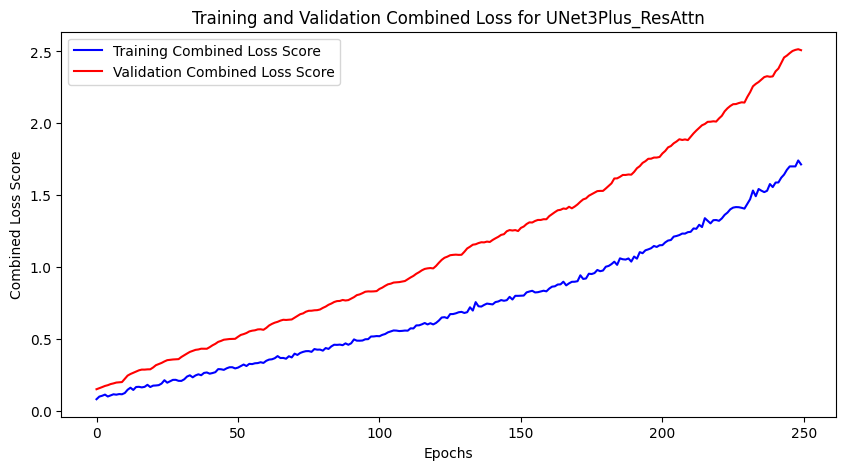

In [22]:
# Plot History
plot_model_history("UNet3Plus_ResAttn", train_history, val_history, 250)

Length of train_loss_history: 0


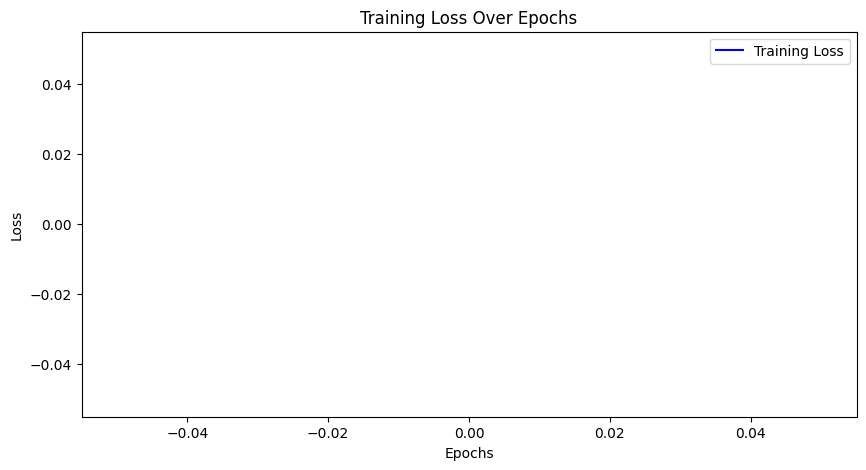

In [23]:
# Verify the length of train_loss_history
print(f"Length of train_loss_history: {len(train_loss_history)}")

# Ensure it matches the number of epochs
num_epochs = len(train_loss_history)

# Modified plot_loss_history function
def plot_loss_history(train_loss_history, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), train_loss_history, 'b', label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Correct Function Call with the actual number of epochs
plot_loss_history(train_loss_history, num_epochs)


Length of val_loss_history: 250


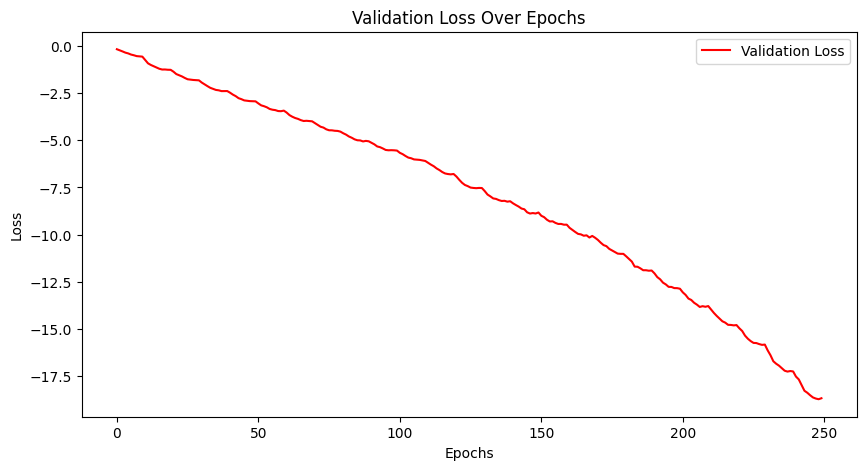

In [24]:
# Verify the length of val_loss_history
print(f"Length of val_loss_history: {len(val_loss_history)}")

# Ensure it matches the number of epochs
num_epochs_val = len(val_loss_history)

# Modified plot_val_loss_history function
def plot_val_loss_history(val_loss_history, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), val_loss_history, 'r', label='Validation Loss')
    plt.title('Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Correct Function Call with the actual number of epochs for validation loss
plot_val_loss_history(val_loss_history, num_epochs_val)


In [25]:
test_dataset = BrainMRIDataset(dataframe=val_df, transform=transform)


In [41]:
print(test_dataset.dataframe.head(40))


                                             image_path  \
1835  gs://medicalsegmentation_test/Kaggle_3m/TCGA_D...   
1490  gs://medicalsegmentation_test/Kaggle_3m/TCGA_D...   
2063  gs://medicalsegmentation_test/Kaggle_3m/TCGA_D...   
1178  gs://medicalsegmentation_test/Kaggle_3m/TCGA_D...   
3749  gs://medicalsegmentation_test/Kaggle_3m/TCGA_H...   
1338  gs://medicalsegmentation_test/Kaggle_3m/TCGA_D...   
2289  gs://medicalsegmentation_test/Kaggle_3m/TCGA_F...   
1448  gs://medicalsegmentation_test/Kaggle_3m/TCGA_D...   
3229  gs://medicalsegmentation_test/Kaggle_3m/TCGA_H...   
1075  gs://medicalsegmentation_test/Kaggle_3m/TCGA_D...   
354   gs://medicalsegmentation_test/Kaggle_3m/TCGA_C...   
2325  gs://medicalsegmentation_test/Kaggle_3m/TCGA_F...   
893   gs://medicalsegmentation_test/Kaggle_3m/TCGA_D...   
2351  gs://medicalsegmentation_test/Kaggle_3m/TCGA_F...   
2506  gs://medicalsegmentation_test/Kaggle_3m/TCGA_F...   
2118  gs://medicalsegmentation_test/Kaggle_3m/TCGA_D... 

In [143]:
idx = 721
# 3121
if idx in test_dataset.dataframe.index:
    print(test_dataset.dataframe.loc[idx])
else:
    print(f"Index {idx} is out of bounds for the dataset")


image_path    gs://medicalsegmentation_test/Kaggle_3m/TCGA_D...
mask_path     gs://medicalsegmentation_test/Kaggle_3m/TCGA_D...
Name: 721, dtype: object


image_path    gs://medicalsegmentation_test/Kaggle_3m/TCGA_D...
mask_path     gs://medicalsegmentation_test/Kaggle_3m/TCGA_D...
Name: 721, dtype: object
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


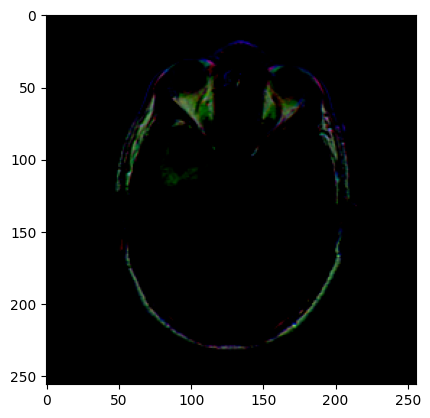

In [144]:
# Print the row at the specified index
if idx in test_dataset.dataframe.index:
    print(test_dataset.dataframe.loc[idx])
else:
    print(f"Index {idx} is out of bounds for the dataset")

# Get the image and mask at the specified index using DataFrame row index
try:
    img_path = test_dataset.dataframe.loc[idx, 'image_path']
    mask_path = test_dataset.dataframe.loc[idx, 'mask_path']
    img_idx = test_dataset.dataframe.index.get_loc(idx)  # Get the positional index

    image, mask = test_dataset[img_idx]

    # Print the mask
    print(mask)

    # Plot the image
    plt.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.show()

except KeyError:
    print(f"Index {idx} is not in the DataFrame")

except Exception as e:
    print(f"An error occurred: {e}")

Sum of the mask: 332265.0


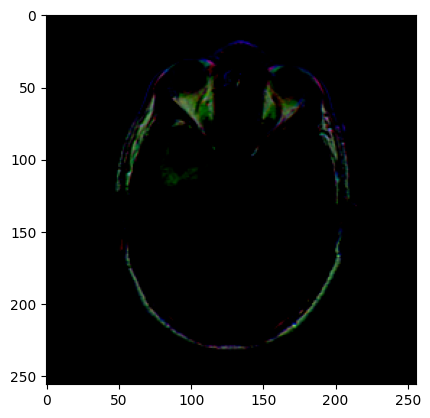

In [145]:
# Sum the mask
mask_sum = mask.sum()
print(f"Sum of the mask: {mask_sum}")

# Plot the image
plt.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
plt.show()


# Assuming you have a tester function defined
def tester(model, dataloader, idx, dataset, device):
    model.eval()
    with torch.no_grad():
        data = dataset[idx]
        inputs, targets = data[0].unsqueeze(0).to(device), data[1].unsqueeze(0).to(device)
        outputs = model(inputs)
        return targets, outputs



In [146]:
import torch

# Define the tester function
def tester(model, dataloader, idx, dataset, device):
    model.eval()
    with torch.no_grad():
        data = dataset[idx]
        # Convert numpy arrays to torch tensors
        inputs, targets = torch.tensor(data[0]).unsqueeze(0).to(device), torch.tensor(data[1]).unsqueeze(0).to(device)
        outputs = model(inputs)
        return targets, outputs

# Perform testing
targ, op = tester(model, val_dataloader, img_idx, test_dataset, device)  # Use val_dataloader as test_dataloader
print("Target:", targ)
print("Output:", op)


Target: tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')
Output: tensor([[[[1.4263, 1.4246, 1.6486,  ..., 1.8876, 1.7103, 0.4760],
          [1.8956, 2.3217, 0.6421,  ..., 1.7569, 1.5188, 2.8207],
          [0.6247, 0.9210, 2.0662,  ..., 1.7782, 1.0527, 1.1895],
          ...,
          [0.7766, 2.5788, 1.3667,  ..., 2.0548, 1.9619, 2.4100],
          [2.7620, 2.6227, 2.2240,  ..., 3.0588, 2.7968, 2.4994],
          [3.0085, 2.0324, 2.4298,  ..., 1.5736, 2.8264, 2.2427]]]],
       device='cuda:0')


<ipython-input-146-0d8e93a49521>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, targets = torch.tensor(data[0]).unsqueeze(0).to(device), torch.tensor(data[1]).unsqueeze(0).to(device)


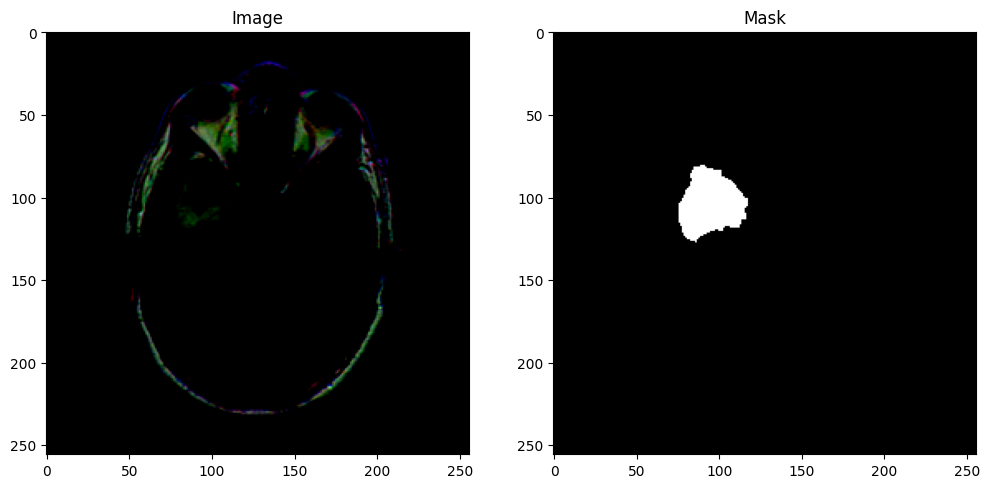

In [147]:
import matplotlib.pyplot as plt

# Assuming image and mask are already obtained from the dataset
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the image
ax[0].imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
ax[0].set_title("Image")

# Display the mask
ax[1].imshow(mask.squeeze(), cmap='gray')  # Squeeze to remove the channel dimension for mask
ax[1].set_title("Mask")

plt.show()


In [106]:
# # Function to calculate Dice score
# def calculate_dice_score(pred, target, smooth=1):
#     pred = torch.sigmoid(pred)
#     pred = (pred > 0.5).float()
#     intersection = (pred * target).sum()
#     dice_score = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
#     return dice_score.item()

# # Assuming targ and op are already obtained from the tester function
# dice_score = calculate_dice_score(op, targ)
# print("Dice Score:", dice_score)


Dice Score: 1.81471848487854


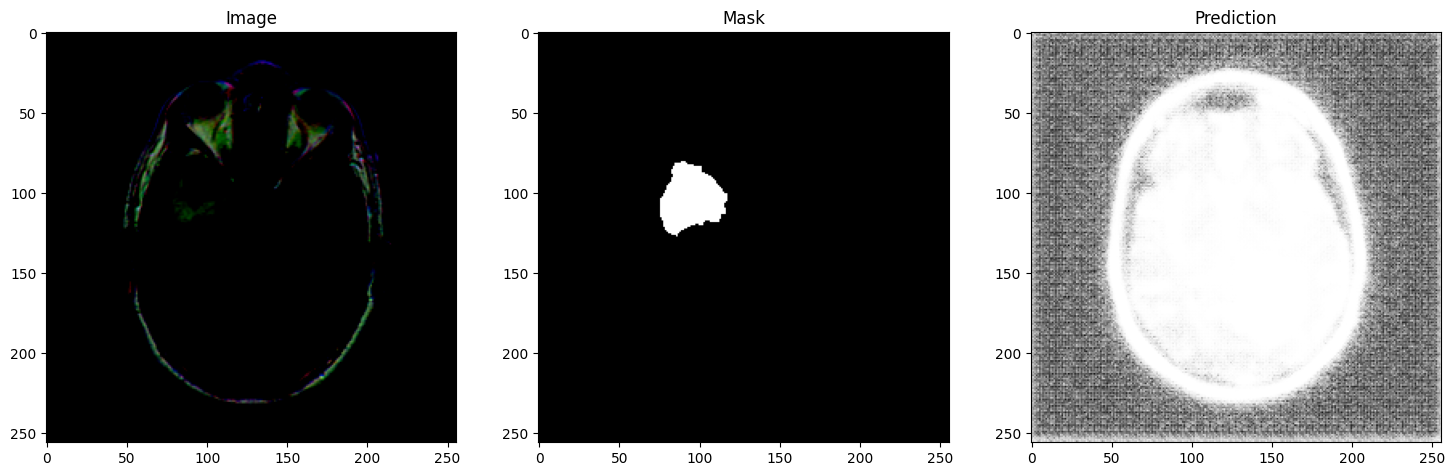

In [148]:
import matplotlib.pyplot as plt

# Assuming image, mask, and prediction are already obtained
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Display the image
ax[0].imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
ax[0].set_title("Image")

# Display the mask
ax[1].imshow(mask.squeeze(), cmap='gray')  # Squeeze to remove the channel dimension for mask
ax[1].set_title("Mask")

# Display the prediction
ax[2].imshow(prediction.squeeze().cpu().detach().numpy(), cmap='gray')  # Convert prediction to numpy array
ax[2].set_title("Prediction")

plt.show()


In [149]:
import torch

def calculate_iou(prediction, target, threshold=0.5):
    # Apply threshold to binarize the prediction
    prediction = (prediction > threshold).float()

    # Calculate intersection and union
    intersection = (prediction * target).sum().float()
    union = prediction.sum() + target.sum() - intersection

    # Compute IoU
    iou = intersection / union

    return iou.item()

# Example usage:
iou = calculate_iou(prediction.squeeze(), mask.squeeze())
print(f"IoU: {iou:.4f}")


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

IoU: 0.0000


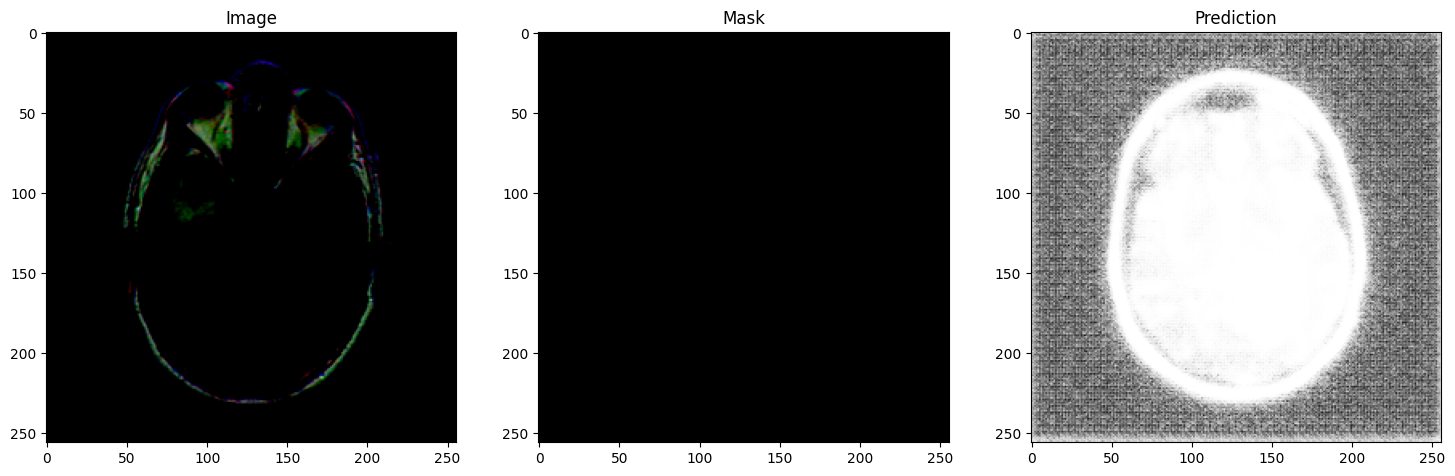

In [154]:
# Ensure both tensors are on the same device (CPU or GPU)
prediction_tensor = prediction_tensor.to(device)
mask_tensor = mask_tensor.to(device)

# Calculate IoU
iou = calculate_iou(prediction_tensor, mask_tensor)
print(f"IoU: {iou:.4f}")

# Convert the prediction back to a NumPy array for plotting
prediction_np = prediction_tensor.cpu().numpy()

# Plot the image, mask, and prediction side by side
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Display the image
ax[0].imshow(image.permute(1, 2, 0).cpu().numpy())  # Ensure image is on CPU and in (H, W, C) format
ax[0].set_title("Image")

# Display the mask
ax[1].imshow(mask_tensor.cpu().numpy().squeeze(), cmap='gray')  # Squeeze to remove the channel dimension for mask
ax[1].set_title("Mask")

# Display the prediction
ax[2].imshow(prediction_np, cmap='gray')
ax[2].set_title("Prediction")

plt.show()


In [151]:
print(mask_tensor.unique())


tensor([0.], device='cuda:0')


In [152]:
mask_tensor = mask_tensor / 255.0  # Normalize to [0, 1]


In [153]:
mask_tensor = (mask_tensor > 0.5).float()


In [155]:
def calculate_iou(prediction, target, threshold=0.5):
    # Binarize predictions
    prediction = (prediction > threshold).float()
    target = target.float()

    # Ensure tensors are binary
    assert prediction.max() <= 1 and prediction.min() >= 0
    assert target.max() <= 1 and target.min() >= 0

    # Calculate intersection and union
    intersection = (prediction * target).sum()
    union = prediction.sum() + target.sum() - intersection

    # IoU calculation
    iou = intersection / (union + 1e-6)
    return iou.item()



In [156]:
print(f"Prediction Tensor: {prediction_tensor}")
print(f"Mask Tensor: {mask_tensor}")
iou = calculate_iou(prediction_tensor, mask_tensor)
print(f"IoU: {iou:.4f}")


Prediction Tensor: tensor([[0.7805, 0.7833, 0.8027,  ..., 0.8487, 0.8453, 0.5815],
        [0.8388, 0.8867, 0.6288,  ..., 0.8584, 0.8245, 0.9388],
        [0.6708, 0.7089, 0.8856,  ..., 0.8278, 0.7476, 0.7480],
        ...,
        [0.6953, 0.9353, 0.7946,  ..., 0.8865, 0.8702, 0.9179],
        [0.9152, 0.9080, 0.8960,  ..., 0.9604, 0.9456, 0.9216],
        [0.9460, 0.8644, 0.9253,  ..., 0.8403, 0.9424, 0.8993]],
       device='cuda:0')
Mask Tensor: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
IoU: 0.0000


In [112]:
import torch

# Function to calculate Dice Score
def calculate_dice(prediction, target, threshold=0.5):
    prediction = (prediction > threshold).float()  # Binarize prediction
    target = (target > threshold).float()  # Binarize target

    intersection = (prediction * target).sum()
    dice = (2. * intersection) / (prediction.sum() + target.sum() + 1e-8)  # Add small epsilon to prevent division by zero

    return dice

# Function to calculate Intersection over Union (IoU)
def calculate_iou(prediction, target, threshold=0.5):
    prediction = (prediction > threshold).float()  # Binarize prediction
    target = (target > threshold).float()  # Binarize target

    intersection = (prediction * target).sum()
    union = prediction.sum() + target.sum() - intersection
    iou = intersection / (union + 1e-8)  # Add small epsilon to prevent division by zero

    return iou

# Assuming prediction_tensor and mask_tensor are defined
iou = calculate_iou(prediction_tensor, mask_tensor)
dice_score = calculate_dice(prediction_tensor, mask_tensor)

print(f"IoU: {iou:.4f}")
print(f"Dice Score: {dice_score:.4f}")


IoU: 0.0000
Dice Score: 0.0000
